In [2]:
#from docopt import docopt
import pandas as pd
import matplotlib.pyplot as plt
import re

# 1. First Data exploration

In [3]:
# Load the DataFrame
pheno_path = "../data/phenotypes/Phenotypic_V1_0b_preprocessed1.csv"
pheno = pd.read_csv(pheno_path)

In [4]:
pd.set_option('display.max_rows', None)

# Display the first few rows of the DataFrame
print("First few rows of the DataFrame:")
display(pheno.head())

# Get general information about the DataFrame
print("\nGeneral information about the DataFrame:")
display(pheno.info())

# Check for missing values
print("\nPercentage of missing values per column:")
nan_percentage = pheno.isna().mean() * 100
nan_percentage_df = nan_percentage[nan_percentage > 0].to_frame(name='NaN Percentage')
nan_percentage_df.columns.name = 'Column'
display(nan_percentage_df)

# Generate descriptive statistics
print("\nDescriptive statistics:")
display(pheno.describe(include='all'))

# Distribution of unique values for each categorical column
print("\nDistribution of unique values for each categorical column:")
categorical_columns = pheno.select_dtypes(include=['object', 'category']).columns
for col in categorical_columns:
    print(f"\nColumn: {col}")
    display(pheno[col].value_counts())

First few rows of the DataFrame:


,Unnamed: 0.1,Unnamed: 0,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,...,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
0,0,1,50002,1,50002,PITT,no_filename,1,1,16.77,...,NaN,OK,NaN,fail,ic-parietal-cerebellum,OK,NaN,fail,ERROR #24,1
1,1,2,50003,2,50003,PITT,Pitt_0050003,1,1,24.45,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
2,2,3,50004,3,50004,PITT,Pitt_0050004,1,1,19.09,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
3,3,4,50005,4,50005,PITT,Pitt_0050005,1,1,13.73,...,NaN,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN,0
4,4,5,50006,5,50006,PITT,Pitt_0050006,1,1,13.37,...,NaN,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN,1



General information about the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112 entries, 0 to 1111
Columns: 106 entries, Unnamed: 0.1 to SUB_IN_SMP
dtypes: float64(77), int64(10), object(19)
memory usage: 921.0+ KB


None


Percentage of missing values per column:


Column,NaN Percentage
HANDEDNESS_CATEGORY,28.327338
HANDEDNESS_SCORES,66.726619
FIQ,3.147482
VIQ,15.917266
PIQ,14.298561
FIQ_TEST_TYPE,14.838129
VIQ_TEST_TYPE,25.000000
PIQ_TEST_TYPE,23.291367
ADI_R_SOCIAL_TOTAL_A,62.949640
ADI_R_VERBAL_TOTAL_BV,62.949640



Descriptive statistics:


,Unnamed: 0.1,Unnamed: 0,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,...,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
count,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112,1112,1112.000000,1112.000000,1112.000000,...,39,1100,275,1100,259,1111,108,1111,76,1112.000000
unique,NaN,NaN,NaN,NaN,NaN,20,1036,NaN,NaN,NaN,...,18,3,16,3,25,2,7,2,47,NaN
top,NaN,NaN,NaN,NaN,NaN,NYU,no_filename,NaN,NaN,NaN,...,dorsal cropped,OK,skull-striping fail,OK,ic-cerebellum,OK,headmotion,OK,no T1,NaN
freq,NaN,NaN,NaN,NaN,NaN,184,77,NaN,NaN,NaN,...,16,866,98,842,130,1003,62,1035,11,NaN
mean,555.500000,556.500000,50752.684353,556.500000,50752.684353,NaN,NaN,1.515288,-646.819245,17.048864,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.686151
std,321.151055,321.151055,447.680666,321.151055,447.680666,NaN,NaN,0.499991,2461.828856,8.036419,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.464265
min,0.000000,1.000000,50002.000000,1.000000,50002.000000,NaN,NaN,1.000000,-9999.000000,6.470000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,277.750000,278.750000,50354.750000,278.750000,50354.750000,NaN,NaN,1.000000,0.000000,11.658575,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,555.500000,556.500000,50724.500000,556.500000,50724.500000,NaN,NaN,2.000000,0.000000,14.660000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,833.250000,834.250000,51153.250000,834.250000,51153.250000,NaN,NaN,2.000000,1.000000,20.085000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000



Distribution of unique values for each categorical column:

Column: SITE_ID


SITE_ID
NYU         184
UM_1        110
USM         101
UCLA_1       82
PITT         57
MAX_MUN      57
YALE         56
KKI          55
TRINITY      49
STANFORD     40
CALTECH      38
SDSU         36
OLIN         36
UM_2         35
LEUVEN_2     35
SBL          30
LEUVEN_1     29
OHSU         28
UCLA_2       27
CMU          27
Name: count, dtype: int64


Column: FILE_ID


FILE_ID
no_filename         77
NYU_0051081          1
NYU_0051051          1
NYU_0051052          1
NYU_0051053          1
NYU_0051054          1
NYU_0051055          1
NYU_0051056          1
NYU_0051057          1
NYU_0051058          1
NYU_0051059          1
NYU_0051060          1
NYU_0051061          1
NYU_0051062          1
NYU_0051063          1
NYU_0051064          1
NYU_0051065          1
NYU_0051066          1
NYU_0051067          1
NYU_0051068          1
NYU_0051069          1
NYU_0051070          1
NYU_0051071          1
NYU_0051072          1
NYU_0051073          1
NYU_0051074          1
NYU_0051075          1
NYU_0051076          1
NYU_0051077          1
NYU_0051078          1
NYU_0051079          1
NYU_0051050          1
NYU_0051049          1
NYU_0051048          1
NYU_0051029          1
NYU_0051015          1
NYU_0051016          1
NYU_0051017          1
NYU_0051018          1
NYU_0051019          1
NYU_0051020          1
NYU_0051021          1
NYU_0051023          1
NYU


Column: HANDEDNESS_CATEGORY


HANDEDNESS_CATEGORY
R        693
L         71
Ambi      15
-9999     11
Mixed      6
L->R       1
Name: count, dtype: int64


Column: FIQ_TEST_TYPE


FIQ_TEST_TYPE
WASI                  551
WISC_IV_FULL          103
WAIS_III               63
DAS_II_SA              56
WST                    41
WISC_III_DUTCH         35
WISC_IV_4_SUBTESTS     33
WISC                   28
WISC_III               15
HAWIK_IV               14
-9999                   4
WAIS                    3
GIT                     1
Name: count, dtype: int64


Column: VIQ_TEST_TYPE


VIQ_TEST_TYPE
WASI            513
PPVT            118
DAS_II_SA        69
WISC_IV_FULL     47
WAIS_III         43
WISC             28
GIT               8
WAIS              3
ppvt              2
WISC4             1
Stanford          1
WISC_III          1
Name: count, dtype: int64


Column: PIQ_TEST_TYPE


PIQ_TEST_TYPE
WASI            513
Ravens          114
DAS_II_SA        70
WISC_IV_FULL     47
WAIS_III         43
WISC             28
RAVENS           22
GIT               8
WAIS              3
ravens            2
WISC4             1
Stanford          1
WISC_III          1
Name: count, dtype: int64


Column: COMORBIDITY


COMORBIDITY
ADHD Inattentive                                                                                              10
ADHD Combined                                                                                                  4
Mood Disorder NOS                                                                                              4
Dysthymia                                                                                                      3
ODD                                                                                                            2
ADHD NOS                                                                                                       2
Generalized Anxiety Disorder                                                                                   2
Specific Phobia: needles/shots                                                                                 1
Disruptive disorder NOS                                                             


Column: CURRENT_MED_STATUS


CURRENT_MED_STATUS
0        673
1        136
-9999      7
`          1
Name: count, dtype: int64


Column: MEDICATION_NAME


MEDICATION_NAME
0                                                                                                     24
Fluoxetine                                                                                             6
Methylphenidate Extended Release                                                                       5
Atomoxetine                                                                                            4
Lisdexamfetamine                                                                                       4
Sertraline                                                                                             4
Escitalopram                                                                                           4
Risperidone                                                                                            3
Guanfacine Extended Release                                                                            2
Guanfacine                             


Column: qc_rater_1


qc_rater_1
OK       997
fail     111
maybe      4
Name: count, dtype: int64


Column: qc_notes_rater_1


qc_notes_rater_1
dorsal cropped                            16
**Not recommended with niak                4
ventral edge is cropped                    4
tip of frontal lobe cropped                1
front lost                                 1
frontal right lobe lost                    1
dorsal cropped. Registration error         1
front left cropped. Registration error     1
registration error (dparsf)                1
wraparound                                 1
frontal lob gone, rest of brain warped     1
cerebellum & brainstem cropped             1
skullstrip error?                          1
fronal lobe low signal                     1
frontal lobe hole. Sinus?                  1
left frontal low signal                    1
misshapen right frontal lobe               1
distorted. Not localized correctly         1
Name: count, dtype: int64


Column: qc_anat_rater_2


qc_anat_rater_2
OK       866
maybe    194
fail      40
Name: count, dtype: int64


Column: qc_anat_notes_rater_2


qc_anat_notes_rater_2
skull-striping fail                      98
skull-striping fail;                     59
skull-striping fail; Motion              30
stripe                                   29
Motion                                   22
motion                                   15
large-ventricals                          5
skull-striping fail; motion artefacts     5
motion, large ventricles                  3
skull-striping fail; motion               2
motion artefacts                          2
bad motion                                1
skull-striping fail; large ventricles     1
no left cerebellum                        1
skull-striping fail; Motion bad           1
skull-striping fail; ic-cerebellum        1
Name: count, dtype: int64


Column: qc_func_rater_2


qc_func_rater_2
OK       842
maybe    207
fail      51
Name: count, dtype: int64


Column: qc_func_notes_rater_2


qc_func_notes_rater_2
ic-cerebellum                              130
Ic-parietal                                 27
ic-cerebellum-temporal_lobe                 16
ic-cerebellum_temporal_lobe                 16
ic-parietal-cerebellum                      13
ic-cerebellum_temporal_lob                   9
ic-frontal-temporal-cerebellum               8
Ic-parietal-minor                            6
ic-temporal-cerebellum                       6
ic-cerebellum-temporal_lobe-vmpfc            4
ic-parietal slight                           4
ic-frontal-temporal-cerebellum-parietal      3
Ic-parietal-cerebellum-temporal              2
ic-parietal                                  2
small brain                                  2
IC-parienta-minor                            2
signal drop off too much                     1
ic-cerebellum; bad image quality             1
OK                                           1
Left parietal signal drop out                1
ic-parietal-occipital                 


Column: qc_anat_rater_3


qc_anat_rater_3
OK      1003
fail     108
Name: count, dtype: int64


Column: qc_anat_notes_rater_3


qc_anat_notes_rater_3
headmotion         62
noise              18
half head          11
no T1, T2          10
less headmotion     5
no anat images      1
quality check       1
Name: count, dtype: int64


Column: qc_func_rater_3


qc_func_rater_3
OK      1035
fail      76
Name: count, dtype: int64


Column: qc_func_notes_rater_3


qc_func_notes_rater_3
no T1                            11
no func images                   11
ERROR #5                          3
bad T1                            2
ERROR #52                         2
ERROR #1                          2
ERROR #216                        2
ERROR #17                         2
bad quality                       2
ERROR #46                         2
ERROR #100                        1
ERROR #58                         1
ERROR #20                         1
ERROR #117                        1
ERROR #40                         1
ERROR #19                         1
ERROR #16                         1
ERROR #88                         1
ERROR #48                         1
ERROR #33                         1
ERROR #12                         1
ERROR #90                         1
ERROR #86                         1
ERROR #50                         1
ERROR #51                         1
ERROR #178                        1
ERROR #24                         1
ERROR 

In [5]:
# Variables of interest
variables_of_interest = ['SITE_ID', 'AGE_AT_SCAN', 'SEX', 'VIQ', 'FIQ', 'PIQ', 'DX_GROUP']

print("\nPercentage of missing values for each variable:")
missing_values_percentage = pheno[variables_of_interest].isna().mean() * 100
missing_values_df = missing_values_percentage.to_frame(name='Missing Values Percentage')
display(missing_values_df)


# Variables of interest
variables_of_interest = ['SITE_ID', 'SEX', 'DX_GROUP']

# Calculate the percentage of modalities for each variable
print("\nPercentage of modalities for each variable:")
modalities_percentage = {}
for var in variables_of_interest:
    value_counts = pheno[var].value_counts(normalize=True) * 100
    modalities_percentage[var] = value_counts

# Display the percentage of modalities for each variable
for var, percentages in modalities_percentage.items():
    print(f"\nVariable: {var}")
    display(percentages.to_frame(name='Percentage'))

# Generate descriptive statistics
print("\nDescriptive statistics:")
display(pheno.describe(include='all'))


Percentage of missing values for each variable:


,Missing Values Percentage
SITE_ID,0.000000
AGE_AT_SCAN,0.000000
SEX,0.000000
VIQ,15.917266
FIQ,3.147482
PIQ,14.298561
DX_GROUP,0.000000



Percentage of modalities for each variable:

Variable: SITE_ID


,Percentage
SITE_ID,
NYU,16.546763
UM_1,9.892086
USM,9.082734
UCLA_1,7.374101
PITT,5.125899
MAX_MUN,5.125899
YALE,5.035971
KKI,4.946043
TRINITY,4.406475



Variable: SEX


,Percentage
SEX,
1,85.251799
2,14.748201



Variable: DX_GROUP


,Percentage
DX_GROUP,
2,51.528777
1,48.471223



Descriptive statistics:


,Unnamed: 0.1,Unnamed: 0,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,...,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
count,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112,1112,1112.000000,1112.000000,1112.000000,...,39,1100,275,1100,259,1111,108,1111,76,1112.000000
unique,NaN,NaN,NaN,NaN,NaN,20,1036,NaN,NaN,NaN,...,18,3,16,3,25,2,7,2,47,NaN
top,NaN,NaN,NaN,NaN,NaN,NYU,no_filename,NaN,NaN,NaN,...,dorsal cropped,OK,skull-striping fail,OK,ic-cerebellum,OK,headmotion,OK,no T1,NaN
freq,NaN,NaN,NaN,NaN,NaN,184,77,NaN,NaN,NaN,...,16,866,98,842,130,1003,62,1035,11,NaN
mean,555.500000,556.500000,50752.684353,556.500000,50752.684353,NaN,NaN,1.515288,-646.819245,17.048864,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.686151
std,321.151055,321.151055,447.680666,321.151055,447.680666,NaN,NaN,0.499991,2461.828856,8.036419,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.464265
min,0.000000,1.000000,50002.000000,1.000000,50002.000000,NaN,NaN,1.000000,-9999.000000,6.470000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,277.750000,278.750000,50354.750000,278.750000,50354.750000,NaN,NaN,1.000000,0.000000,11.658575,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,555.500000,556.500000,50724.500000,556.500000,50724.500000,NaN,NaN,2.000000,0.000000,14.660000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,833.250000,834.250000,51153.250000,834.250000,51153.250000,NaN,NaN,2.000000,1.000000,20.085000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


## 2. Data cleaning, statistics and charts

In [66]:
def load_phenotypes(pheno_path):

    pheno = pd.read_csv(pheno_path)
    pheno = pheno[pheno['FILE_ID'] != 'no_filename']
    #pheno = pheno[pheno['FILE_ID'].str.contains("NYU")]
    pheno['DX_GROUP'] = pheno['DX_GROUP'].apply(lambda v: int(v)-1)
    pheno['SITE_ID'] = pheno['SITE_ID'].apply(lambda v: re.sub('_[0-9]', '', v))
    pheno['SEX'] = pheno['SEX'].apply(lambda v: {1: "M", 2: "F"}[v])
    pheno['MEAN_FD'] = pheno['func_mean_fd']
    pheno['SUB_IN_SMP'] = pheno['SUB_IN_SMP'].apply(lambda v: v == 1)
    pheno["STRAT"] = pheno[["SITE_ID", "DX_GROUP"]].apply(lambda x: "_".join([str(s) for s in x]), axis=1)
    pheno["AGE"] = pheno['AGE_AT_SCAN']

    #pheno["FIQ"] = pheno['FIQ'].apply(lambda v: {-9999: '100'}[v])
    pheno["FIQ"] = pheno['FIQ'].fillna(pheno['FIQ'].mean())
    pheno["PIQ"] = pheno['PIQ'].fillna(pheno['PIQ'].mean())
    pheno["VIQ"] = pheno['VIQ'].fillna(pheno['VIQ'].mean())


    pheno['HANDEDNESS_SCORES'] = pheno['HANDEDNESS_SCORES'].fillna(method='bfill')
    pheno.index = pheno['FILE_ID']

    return pheno[['FILE_ID', 'DX_GROUP', 'SEX', 'SITE_ID', 'MEAN_FD', 'SUB_IN_SMP', 'STRAT','AGE','HANDEDNESS_SCORES','FIQ']]

def set_common_properties(ax, xlabel, ylabel, fontsize=28, rotation=0):
    """Set common properties for all charts."""
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.set_title(ax.get_title(), fontsize=fontsize + 4)
    ax.tick_params(axis='x', labelsize=fontsize - 2, rotation=rotation)  # Rotate x-axis labels
    ax.tick_params(axis='y', labelsize=fontsize - 2)

def calculate_percentage(counts, total):
    return (counts / total) * 100

def calculate_age_groups(pheno):

    total_count = len(pheno)
    age_under_15 = len(pheno[pheno["AGE"] < 15])
    age_15_to_30 = len(pheno[(pheno["AGE"] >= 15) & (pheno["AGE"] <= 30)])
    age_above_30 = len(pheno[pheno["AGE"] > 30])

    age_groups_percentage = {
        "Under 15": (age_under_15 / total_count) * 100,
        "15 to 30": (age_15_to_30 / total_count) * 100,
        "Above 30": (age_above_30 / total_count) * 100
    }
    return age_groups_percentage

def calculate_site_stats(pheno):
    site_stats = []

    for site, group in pheno.groupby("SITE_ID"):
        site_total = len(group)
        male_count = len(group[group["SEX"] == "M"])
        female_count = len(group[group["SEX"] == "F"])
        asd_count = len(group[group["DX_GROUP"] == 0])
        control_count = len(group[group["DX_GROUP"] == 1])
        under_15 = len(group[group["AGE"] < 15])
        age_15_30 = len(group[(group["AGE"] >= 15) & (group["AGE"] <= 30)])
        above_30 = len(group[group["AGE"] > 30])

        site_stats.append({
            "Site": site,
            "Total": site_total,
            "Male (%)": (male_count / site_total) * 100,
            "Female (%)": (female_count / site_total) * 100,
            "ASD (%)": (asd_count / site_total) * 100,
            "Control (%)": (control_count / site_total) * 100,
            "Under 15 (%)": (under_15 / site_total) * 100,
            "15-30 (%)": (age_15_30 / site_total) * 100,
            "Above 30 (%)": (above_30 / site_total) * 100,
        })
    
    return pd.DataFrame(site_stats)

def display_charts(site_stats_df, site_percentage, gender_percentage, asd_percentage, age_groups_percentage):
    """
    Generate and save various charts from the phenotypic data.
    """
           
    # Site Distribution
    plt.figure(figsize=(10, 6))
    ax = site_percentage.plot(kind="bar", color='blue', title="Site Distribution")
    set_common_properties(plt.gca(), "Site", "Percentage", rotation= 45)
    # plt.xticks(rotation=25, ha='center')  # Rotate x-axis labels
    plt.tight_layout()
    #plt.savefig('site_distribution.png', dpi=300)
    plt.savefig('site_distribution.eps', format='eps', bbox_inches='tight')  # Save as EPS
    plt.show()


    # Gender Distribution
    plt.figure(figsize=(10, 6))
    ax = gender_percentage.plot(kind="bar", color=['blue', 'orange'], title="Gender Distribution")
    set_common_properties(plt.gca(), "Gender", "Percentage")
    plt.tight_layout()
    #plt.savefig('gender_distribution.png', dpi=300)
    plt.savefig('gender_distribution.eps', format='eps', bbox_inches='tight')  # Save as EPS
    plt.show()

    # ASD vs Control
    plt.figure(figsize=(10, 6))
    ax = asd_percentage.plot(kind="bar", color=['green', 'red'], title="ASD vs Control Percentage")
    set_common_properties(plt.gca(), "Group", "Percentage")
    plt.tight_layout()
    #plt.savefig('asd_vs_control_distribution.png', dpi=300)
    plt.savefig('asd_vs_control_distribution.eps', format='eps', bbox_inches='tight')  # Save as EPS
    plt.show()

   # Age Groups
    age_groups_series = pd.Series(age_groups_percentage)
    plt.figure(figsize=(10, 6))  # Set figure size
    ax = age_groups_series.plot(kind="bar", color=['purple', 'skyblue', 'salmon'], title="Age Group Distribution")
    set_common_properties(ax, "Age Group", "Percentage")
    plt.tight_layout()  # Adjust layout
    plt.savefig('age_distribution.eps', format='eps', bbox_inches='tight')  # Save as EPS
    plt.show()


    # Age Groups by Site
    age_group_data = site_stats_df[['Site', 'Under 15 (%)', '15-30 (%)', 'Above 30 (%)']].set_index('Site')
    plt.figure(figsize=(10, 6))
    ax = age_group_data.plot(kind="bar", stacked=True, figsize=(10, 8), title="Age Group Distribution by Site", color=['#FF9999', '#66B2FF', '#99FF99'])
    set_common_properties(plt.gca(), "Site", "Percentage", rotation=45)
    plt.legend(title="Age Group", fontsize=12)
    plt.tight_layout()
    #plt.savefig('age_site_distribution.png', dpi=300)
    plt.savefig('age_site_distribution.eps', format='eps', bbox_inches='tight')  # Save as EPS
    plt.show()


/var/folders/_p/stbgbx154_v2mk71nn05yw5r0000gn/T/ipykernel_97289/4259965439.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pheno['HANDEDNESS_SCORES'] = pheno['HANDEDNESS_SCORES'].fillna(method='bfill')


,Site,Total,Male (%),Female (%),ASD (%),Control (%),Under 15 (%),15-30 (%),Above 30 (%)
0,CALTECH,37,78.378378,21.621622,51.351351,48.648649,0.000000,72.972973,27.027027
1,CMU,27,77.777778,22.222222,51.851852,48.148148,0.000000,74.074074,25.925926
2,KKI,48,75.000000,25.000000,41.666667,58.333333,100.000000,0.000000,0.000000
3,LEUVEN,63,87.301587,12.698413,46.031746,53.968254,41.269841,57.142857,1.587302
4,MAX_MUN,52,92.307692,7.692308,46.153846,53.846154,25.000000,46.153846,28.846154
5,NYU,175,79.428571,20.571429,42.857143,57.142857,61.142857,36.000000,2.857143
6,OHSU,26,100.000000,0.000000,46.153846,53.846154,96.153846,3.846154,0.000000
7,OLIN,34,85.294118,14.705882,55.882353,44.117647,29.411765,70.588235,0.000000
8,PITT,56,85.714286,14.285714,51.785714,48.214286,39.285714,48.214286,12.500000
9,SBL,30,100.000000,0.000000,50.000000,50.000000,0.000000,33.333333,66.666667


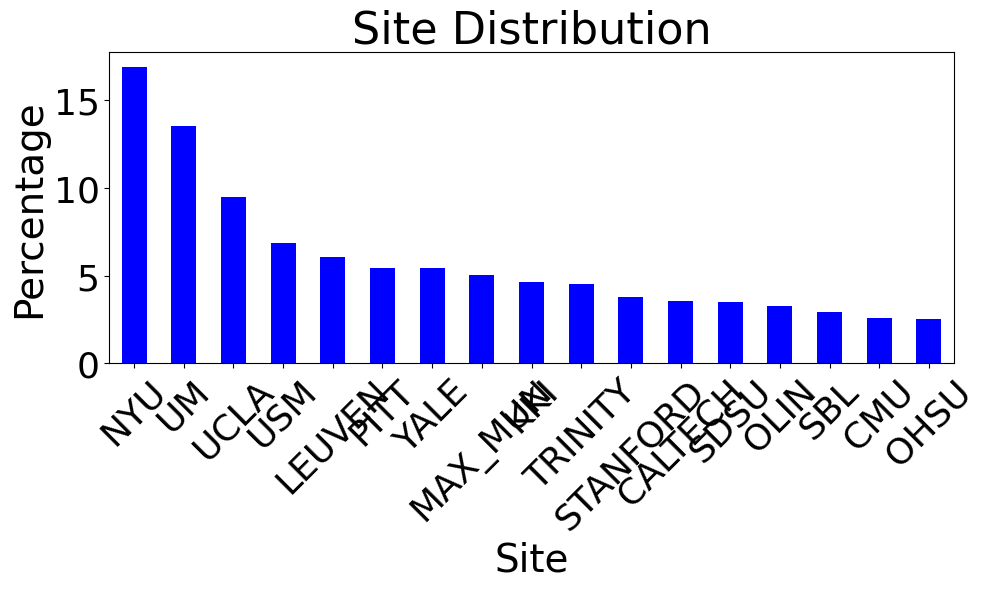

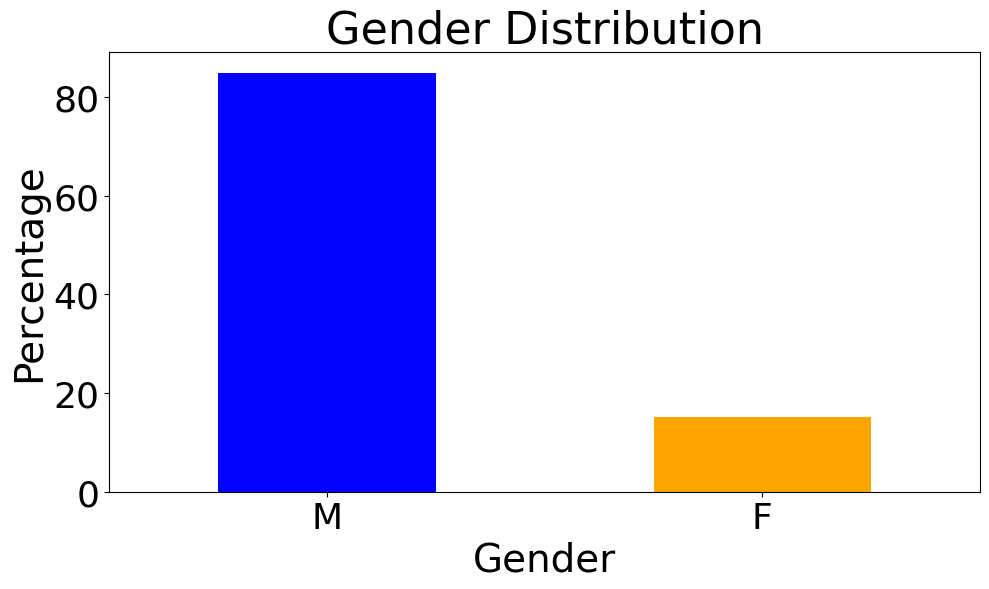

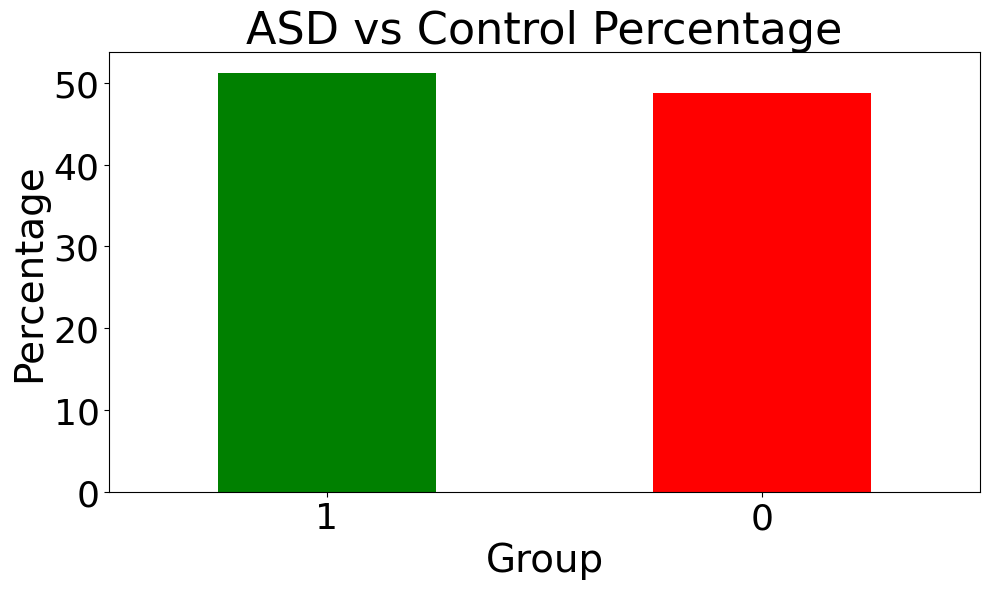

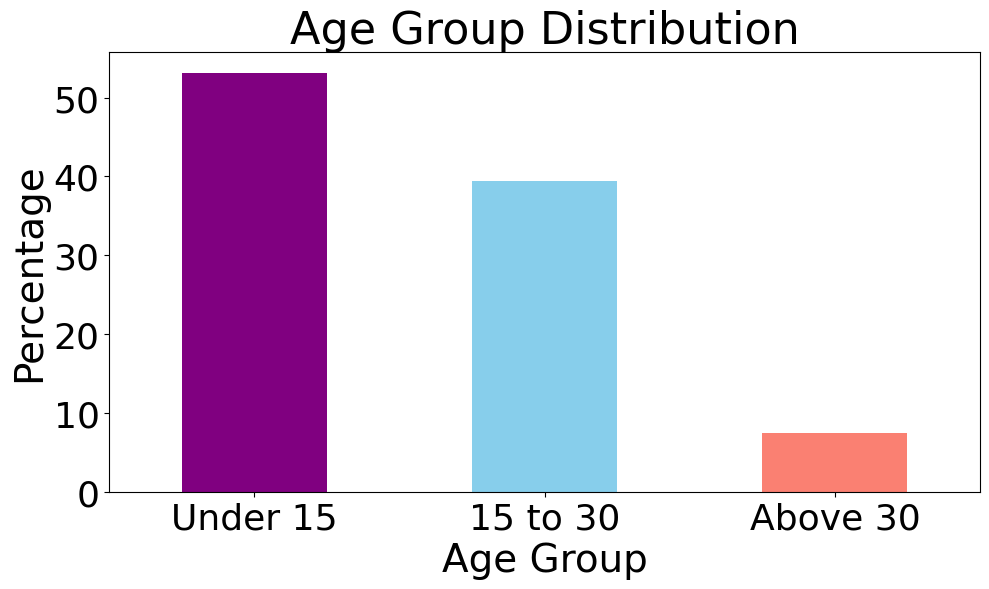

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 1000x600 with 0 Axes>

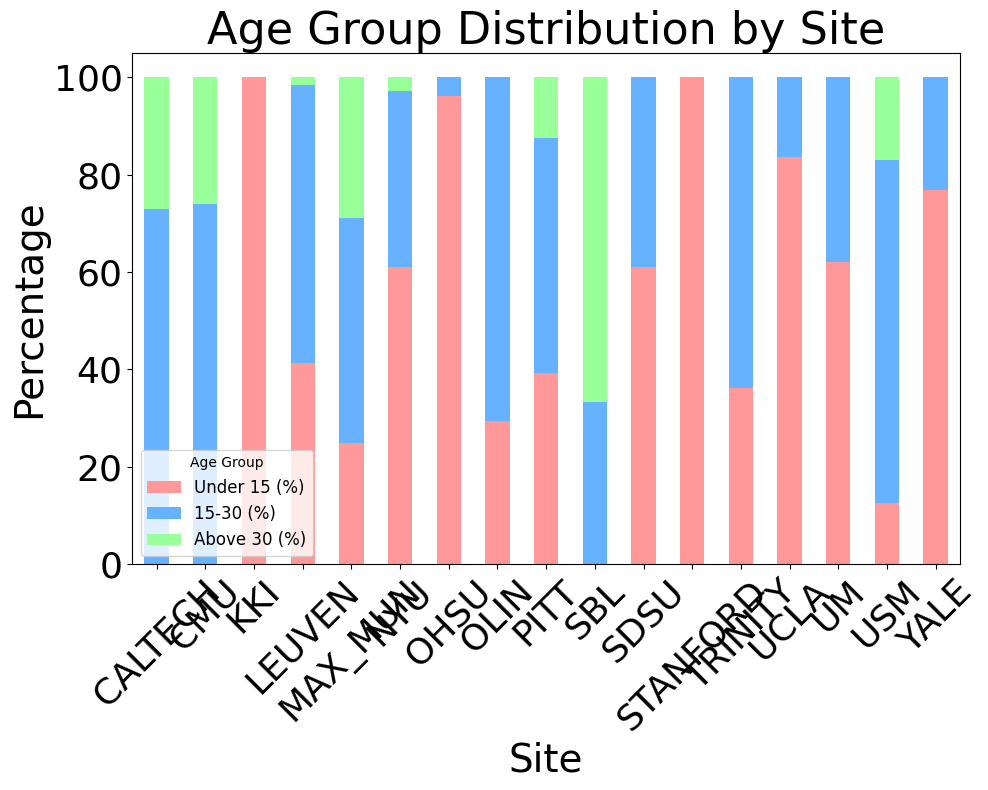

In [67]:
if __name__ == "__main__":
    # Example CSV loading
    pheno_path = "../data/phenotypes/Phenotypic_V1_0b_preprocessed1.csv"
    pheno = load_phenotypes(pheno_path)

    # Calculate statistics
    total_count = len(pheno)
    site_percentage = calculate_percentage(pheno["SITE_ID"].value_counts(), total_count)
    gender_percentage = calculate_percentage(pheno["SEX"].value_counts(), total_count)
    asd_percentage = calculate_percentage(pheno["DX_GROUP"].value_counts(), total_count)
    age_groups_percentage = calculate_age_groups(pheno)
    site_stats_df = calculate_site_stats(pheno)

    # General statistics
    display(site_stats_df)

    
    # Generate and display charts
    display_charts(site_stats_df, site_percentage, gender_percentage, asd_percentage, age_groups_percentage)

